# Imports

In [ ]:
import shutil
import random
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Javascript
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from random import shuffle
from PIL import Image
from pathlib import Path

#------
import json
import tensorflow.keras.models as tf_models
import torch
import torch.nn as nn # all the relevant building blocks
import torch.nn.functional as F # functional interfaces for many operations
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import datetime

import tensorflow as tf
!pip install tf2onnx
import tf2onnx


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [142]:
classes =  ['yes','no','please','sorry','hello','wait','food','thankyou','home','help']

# Preparing images

In [143]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, classes, augment=True):
        """
        Args:
            images_dir (string): Path to the directory with all the images.
            classes (list): List of class names.
            augment (bool, optional): Whether to augment the images produced by the dataset.
        """
        self.images_dir = images_dir
        self.classes = classes
        self.augment = augment

        images_set = os.listdir(images_dir)
        self.images = [Image.open(os.path.join(images_dir, file_name)) for file_name in images_set]
        self.labels = [file_name.split('_')[0] for file_name in images_set]

        if augment:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        try:
            label_tensor = torch.tensor(self.classes.index(label))
        except:
            label_tensor = torch.tensor(-1)
        image = self.transform(image)

        return image, label_tensor


In [144]:
train_dataset = CustomDataset(images_dir="/kaggle/input/hand-sign-classification-cv-in-machine-learning/data/train",classes=classes, augment=True)
val_dataset = CustomDataset(images_dir="/kaggle/input/hand-sign-classification-cv-in-machine-learning/data/val",classes=classes, augment=False)


In [145]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(1))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

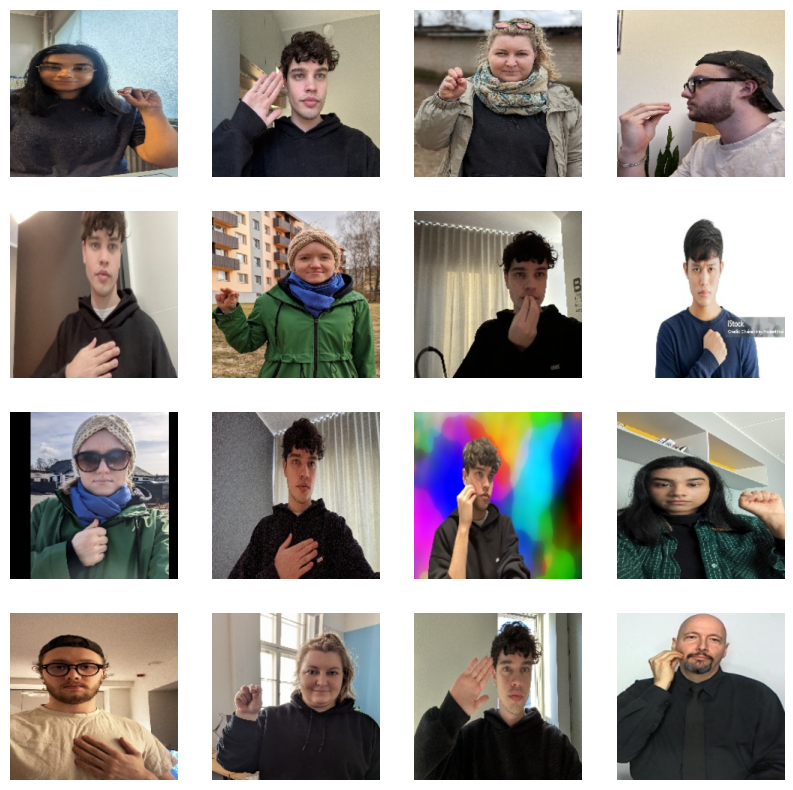

In [146]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

for X_batch, y_batch in train_loader:
    for i in range(16):  # Display all 16 images from the batch
        plt.subplot(4, 4, 1 + i)  # Adjust the subplot layout for a 4x4 grid
        plt.imshow(X_batch[i].numpy().transpose(1, 2, 0))
        plt.axis('off')
    plt.show()
    break  # Exit the loop after displaying the first batch


# Train Model

In [147]:

# Define the neural network architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate the model
#model = CNN(num_classes=len(classes))
config_file = '/kaggle/input/resnetv2/keras/resnet34_v2/2/config.json'

with open(config_file, 'r') as f:
    config_str = f.read()
    
model = tf_models.model_from_json(config_str, custom_objects=None)

model.layers[-1].output_shape = (None, len(classes))
model.layers[-1].units = len(classes)
model.layers[-1].activation = 'softmax'

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Assuming you have your dataset prepared as X_train, y_train, X_test, y_test
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


"""
model.train()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item() * images.size(0)

    # Print average training loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
"""


AttributeError: 'ResNetV2Backbone' object has no attribute 'train'

# Your Model

In [ ]:
prediction = {}
model.eval()
correct = 0
total = 0
i=0
batch_size = 8
with torch.no_grad():
    for images, _labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for j in range(batch_size):
            index = j+1+i*8
            if index < 200:
                prediction[index] = classes[predicted[j].item()]
        i+=1
        
#----saving to final csv-----

submission = {"id": list(prediction.keys()), "label": list(prediction.values())}
submission_df = pd.DataFrame(submission)

now = datetime.datetime.now()
date = f"{now.day}-May_{3+now.hour}h{now.minute}"
output_path = f"/kaggle/working/submission__{date}.csv"

submission_df.to_csv(output_path, index=False)

print(submission_df)

# Submission File 

In [ ]:
#I am uploading the submission.csv manually

"""
import shutil
import os
# Define source and destination paths
source_file = '/kaggle/input/json-file/kaggle.json'
destination_dir = '/root/.kaggle/'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Copy kaggle.json to the correct directory
shutil.copy(source_file, destination_dir)
"""


In [ ]:
"""
import kaggle

# Path to your submission file
submission_file = 'sample_submission.csv'

# Competition URL ( your competition's URL)
competition_url = 'https://www.kaggle.com/competitions/hand-sign-classification-cv-in-machine-learning'

# Extract competition name from the URL
competition_name = competition_url.split('/')[-1]

# Make the submission
kaggle.api.competition_submit(submission_file, "Sample submission", competition_name)

print("Submission successful!")
"""